# MNIST Digits Classification using Neural Networks



In this part we will implement our first Neural Network!
We will use fully connecter Neural Network in order to classify handwritten digits. We will use the well known MNIST dataset. The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning.
![img](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

## Imports

In [1]:
#importing modules that will be in use
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import time
import copy


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split



Mount your drive in order to run locally with colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Deep Learning/Assignment 2/FC
from utils import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Deep Learning/Assignment 2/FC


**QUESTION 1**: What are the problems with sigmoid?

**ANSWER**: 



*   In a large area, the function has zero derivatives, which means that there are many cases where we don't have gradients that we can improve
*   The output range isn't centered around zero.










here we will implement the sigmoid activation function and it's gradient. You should not use any build-in function of sigmoid.

In [3]:

def sigmoid(x):
    # impement the sigmoid funciton
    # ====== YOUR CODE: ======
    sig = 1/(1 + torch.exp(-x))
    # ========================
    return sig



def softmax(x):
    """
  Softmax loss function, should be implemented in a vectorized fashion (without loops)


  Inputs:
  - X: A torch array of shape (N, C) containing a minibatch of data.
  Returns:
  - probabilities: A torch array of shape (N, C) containing the softmax probabilities.

     """
    #for stability (do not change)
    max_per_row, inds = torch.max(x, dim=1)
    x = (x.T - max_per_row).T
    
    # ====== YOUR CODE: ======   
    probabilities = torch.exp(x)/ sum(torch.exp(x))
    # ========================
    return probabilities

Implement a fully-vectorized loss function for the Softmax classifier.


In [4]:
def cross_entropy_error(y, t):
    """
    Inputs:

    - t:  A torch array of shape (N,C) containing  a minibatch of training label. it is a one-hot array, 
      with t[GT]=1 and t=0 elsewhere, where GT is the ground truth label ; 
    - y: A torch array of shape (N, C) containing the softmax probabilities (the NN's output).

    Returns:
    - loss as single float (do not forget to divide by the number of samples in the minibatch (N))
    """
    # ====== YOUR CODE: ======   
    # Compute loss 
    y_size = y.shape[0]
    error = -torch.sum(t*torch.log(y))/y_size
    # ========================
    return error

In [5]:
def get_accuracy(y, t):
    """
    Computes the accuracy of the NN's predictions.
    Inputs:
    - t:  A torch array of shape (N,C) containing training labels, it is a one-hot array, 
      with t[GT]=1 and t=0 elsewhere, where GT is the ground truth label ; 
    - y: the torch probabilities for the minibatch (at the end of the forward pass) of shape (N,C)
    Returns:
    - accuracy: a single float of the average accuracy.
    """
    # ====== YOUR CODE: ======  
    pass
    tmax = torch.argmax(t, dim=1)
    ymax = torch.argmax(y, dim=1)
    correct = (tmax.cpu().numpy() == ymax.cpu().numpy()).sum()
    accuracy = float(correct / y.shape[0])
    # ========================    
    return accuracy

## Fully-connected Network

We will design and train a two-layer fully-connected neural network with sigmoid nonlinearity and
softmax cross entropy loss. We assume an input dimension of D=784, a hidden dimension of H, and perform classification over C classes.

The architecture should be fullyconnected -> sigmoid -> fullyconnected -> softmax.

We will use torch.nn for the linear functions



### config

In [6]:
args={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=15  #The number of Epochs
args['validation_ratio']=0.15 #The validation ratio from training set  
args['eval_every']=1 #Will evaluate the model ever <eval_every> epochs

## load the data

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("using " + device)

using cuda


In [8]:
def create_train_validation_loaders(dataset: Dataset, 
                                         validation_ratio,
                                         batch_size=100):
    """
    Splits a dataset into a train and validation set, returning a
    DataLoader for each.
    :param dataset: The original dataset.
    :param validation_ratio: Ratio (in range 0,1) of the validation set size to
        total dataset size.
    :param batch_size: Batch size the loaders will return from each set.
    :return: A tuple of train, validation and test DataLoader instances.
    """
    if not(0.0 < validation_ratio < 1.0):
        raise ValueError(validation_ratio)
        
        
    # TODO: Create two DataLoader instances, dataloader_train and dataloader_valid.
    # They should together represent a train/validation split of the given
    # dataset. Make sure that:
    # 1. Validation set size is validation_ratio * total number of samples.
    # 2. No sample is in both datasets. You can select samples at random
    #    from the dataset.
    # 3. you use shuffle=True in the train dataloader and shuffle=False in the validation dataloder
    

    # ====== YOUR CODE: ======
    train_dataset, validation_dataset = train_test_split(dataset, test_size = validation_ratio, shuffle= True)
    
    dl_train = DataLoader(train_dataset, batch_size, shuffle=True)
    dl_valid = DataLoader(validation_dataset, batch_size, shuffle=False)
    # ========================

    return dl_train, dl_valid

In [9]:
#load the data
dataset = datasets.MNIST('./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor(),
                                                       transforms.Normalize((0.1307,), (0.3081,))])
                        )

train_loader, val_loader = create_train_validation_loaders(dataset, 
                                                           validation_ratio = args['validation_ratio'],
                                                           batch_size= args['batch_size'])

In [10]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=False)

In [11]:
dataloaders = {'training':train_loader,
               'val':val_loader,
               'test':test_loader
              }

## Fully connected Neural Network

In [12]:
class FullyConnectedNeuralNetwork(nn.Module):
    #This defines the structure of the NN.
    def __init__(self,
                 hidden_layer_dim
                 ):
      super(FullyConnectedNeuralNetwork, self).__init__()
      # Define the model layers. 
      # Use the torch.nn.Linear layers. Set the hidden layer dim to hidden_layer_dim. 
      # Notice that the input dim is 784 and the output dim is 10 (number of classes).
      # ====== YOUR CODE: ======
      self.fc1 = torch.nn.Linear(784, hidden_layer_dim)
      self.fc2 = nn.Linear(hidden_layer_dim, 10)
      # ========================

    def forward(self, x):
      x = torch.flatten(x, start_dim=1,end_dim=-1)
      # ====== YOUR CODE: ======
      x = sigmoid(self.fc1(x))
      y = softmax(self.fc2(x))
      # ========================
      return y

The following functions will train our model

In [13]:
def forward_one_epoch(loader,
                      optimizer,
                      net,
                      mode,
                      progress_bar_str,
                      num_of_epochs
                     ):
    

    losses, cur_accuracies = [], []
    all_preds,all_targets = [], []
    for batch_idx, (inputs, targets) in enumerate(loader):
        
        if mode == Mode.training:
            optimizer.zero_grad()
            
        inputs, targets =inputs.to(device), targets.to(device)
        outputs = net(inputs)
        targets = F.one_hot(targets, num_classes=10)
        loss = cross_entropy_error(outputs, targets)
        losses.append(loss.item())

        if mode == Mode.training:
            #do a step 
            loss.backward()
            optimizer.step()
            
        if len(targets.shape) ==2:
            cur_accuracies.append(get_accuracy(outputs, targets))
            
        if batch_idx %20 ==0:
            progress_bar(batch_idx, len(loader), progress_bar_str
                   % (num_of_epochs, np.mean(losses), losses[-1], np.mean(cur_accuracies)))
            
        targets_cpu = targets.cpu().data.numpy()
        outputs_cpu = [i.cpu().data.numpy() for i in outputs]
        outputs_cpu = np.argmax(outputs_cpu, axis=1)

        all_targets.extend(targets_cpu)
        all_preds.extend(outputs_cpu)

        del inputs, targets, outputs
        torch.cuda.empty_cache()


    return losses, cur_accuracies, all_targets, all_preds




In [14]:
def train(args, dataloaders):
  seed = 0
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)

  model = FullyConnectedNeuralNetwork(hidden_layer_dim = args['hidden_layer_dim'])
  model = model.to(device)

  optimizer = torch.optim.SGD(model.parameters(), args['lr'])

  training_accuracies, val_accuracies = [], []
  training_losses, val_losses = [], [] 


  training_loader = dataloaders['training']
  val_loader = dataloaders['val']
  test_loader = dataloaders['test']

  best_acc = -1

  #start training
  for epoch in range(1, args['epochs']+1):

      #training
      model = model.train()

      progress_bar_str = 'Train: repeat %d -- Mean Loss: %.3f | Last Loss: %.3f | Train Acc: %.3f%%' 

      losses, cur_training_accuracies, _,_ =  forward_one_epoch(
          loader = training_loader,
          optimizer = optimizer,
          net = model,
          mode = Mode.training,
          progress_bar_str = progress_bar_str,
          num_of_epochs = epoch)


      train_epoch_acc = np.mean(cur_training_accuracies)
      train_epoch_loss= np.mean(losses)
      sys.stdout.flush()
      print()
      print(f'Train epoch {epoch}: accuracy {train_epoch_acc}, loss {train_epoch_loss}', flush=True)
      training_accuracies.append(train_epoch_acc)
      training_losses.append(train_epoch_loss)



      # validation
      model.eval()
      if (epoch-1)%args['eval_every']==0:
          progress_bar_str = 'Validation: repeat %d -- Mean Loss: %.3f | Last Loss: %.3f | val Acc: %.3f%%'

          losses, cur_val_accuracies,_,_ =  forward_one_epoch(val_loader,
                                                                optimizer,
                                                                model,
                                                                Mode.validation,
                                                                progress_bar_str,
                                                                epoch
                                                              )
          val_epoch_acc= np.mean(cur_val_accuracies)
          val_epoch_loss= np.mean(losses)
          sys.stdout.flush()
          val_accuracies.append(val_epoch_acc)

          val_epoch_acc = np.round(val_epoch_acc,3)
          print()
          print(f'Validation epoch {epoch//args["eval_every"]}: accuracy {val_epoch_acc}, loss {val_epoch_loss}', flush=True)
          val_losses.append(val_epoch_loss)
          
          cur_acc_loss = {
            'training_accuracies':training_accuracies,
            'val_accuracies':val_accuracies,
            'training_losses':training_losses,
            'val_losses':val_losses
                        }

          if best_acc +0.001 < val_epoch_acc:

              best_acc = val_epoch_acc
              best_acc_epoch = epoch

              print(f'========== new best model! epoch {best_acc_epoch}, accuracy {best_acc}  ==========')
              best_model = copy.deepcopy(model)

              
  progress_bar_str = 'Test: repeat %d -- Mean Loss: %.3f | Last Loss: %.3f | Acc: %.3f%%'
  test_losses, test_cur_test_accuracies, test_all_targets, test_all_preds = forward_one_epoch(test_loader,
                                                                None,
                                                                best_model,
                                                                Mode.test,
                                                                progress_bar_str,
                                                                0)

  test_epoch_acc= np.mean(test_cur_test_accuracies)
  test_epoch_loss= np.mean(test_losses)
  print("===================== Test Results =====================")
  print(f'Test Accuracy : {test_epoch_acc}')
  print(f'Test Loss : {test_epoch_loss}')
  return best_model, cur_acc_loss 

## Training Process

We will finetune two hyper parameters:
1. The hidden layer dimension.
2. The learning rate.

### Finetuning hidden_layer_dim 

#### hidden_layer_dim = 1, lr = 0.0001  

Set the hidden_layer_dim to 1 and the lr to 0.0001 and train the model.

In [15]:
args['hidden_layer_dim'] = 1
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.1282549019607843, loss 6.90718235689051

Validation epoch 1: accuracy 0.132, loss 6.906483173370361
========== new best model! epoch 1, accuracy 0.132  ==========

Train epoch 2: accuracy 0.13094117647058823, loss 6.906625392390232

Validation epoch 2: accuracy 0.133, loss 6.905924161275228

Train epoch 3: accuracy 0.13250980392156864, loss 6.906056637857475

Validation epoch 3: accuracy 0.134, loss 6.905375904507107
========== new best model! epoch 3, accuracy 0.134  ==========

Train epoch 4: accuracy 0.1342352941176471, loss 6.905489416683421

Validation epoch 4: accuracy 0.136, loss 6.904838191138373
========== new best model! epoch 4, accuracy 0.136  ==========

Train epoch 5: accuracy 0.1367450980392157, loss 6.9049697389789655

Validation epoch 5: accuracy 0.138, loss 6.904311392042372
========== new best model! epoch 5, accuracy 0.138  ==========

Train epoch 6: accuracy 0.14019607843137255, loss 6.904410399642646

Validation epoch 6: accuracy 0.14, l

Best val accuracy was 0.15733333333333333, at epoch 14


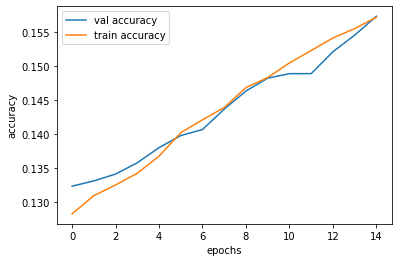

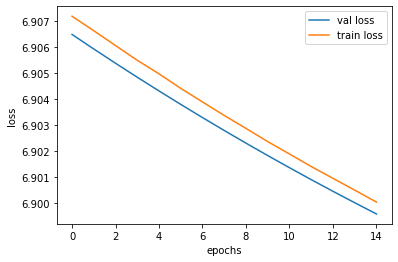

0.15733333333333333

In [16]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.1**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: 

Test Accuracy : 0.16090000000000002 

Test Loss : 6.898997831344604

On the graph we can see that as we make more epochs the model is getting better and the accuracy is increasing while the loss is decreasing.

Despite the improvements, accuracy is still low, and the loss is still high, which suggests that the hidden layer dim is too small, which weakens the model.


#### hidden_layer_dim = 5, lr = 0.0001

Set the hidden_layer_dim to 5 and the lr to 0.0001 and train the model.

In [19]:
args['hidden_layer_dim'] = 5
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.1523137254901961, loss 6.886615397883396

Validation epoch 1: accuracy 0.155, loss 6.8851890034145775
========== new best model! epoch 1, accuracy 0.155  ==========

Train epoch 2: accuracy 0.1558235294117647, loss 6.8856118146110985

Validation epoch 2: accuracy 0.16, loss 6.88416247897678
========== new best model! epoch 2, accuracy 0.16  ==========

Train epoch 3: accuracy 0.15998039215686277, loss 6.8846141871284035

Validation epoch 3: accuracy 0.163, loss 6.883140987820095
========== new best model! epoch 3, accuracy 0.163  ==========

Train epoch 4: accuracy 0.16284313725490193, loss 6.88358652825449

Validation epoch 4: accuracy 0.168, loss 6.88212341732449
========== new best model! epoch 4, accuracy 0.168  ==========

Train epoch 5: accuracy 0.16670588235294118, loss 6.882586310891544

Validation epoch 5: accuracy 0.171, loss 6.881110032399495
========== new best model! epoch 5, accuracy 0.171  ==========

Train epoch 6: accuracy 0.1706078431372549,

Best val accuracy was 0.2121111111111111, at epoch 14


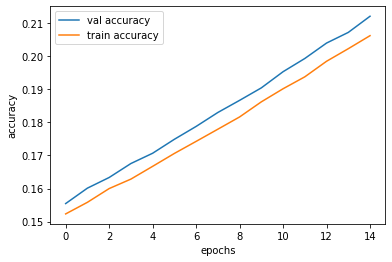

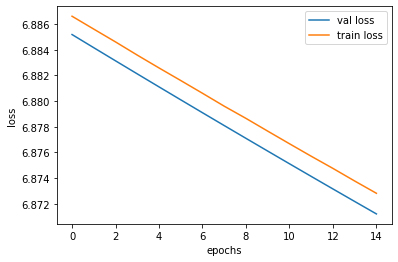

0.2121111111111111

In [20]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.2**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: 

Test Accuracy : 0.20949999999999996

Test Loss : 6.871298027038574

The graphs are similar to the previous graphs, but one can see that after increasing the hidden layer dimension, the accuracy has improved, and the loss has decreased, although it's still not good enough, we can also see that the improvement between epochs is very small, which implies that the learning rate is too low, and the hidden layer dimension is still too small.


#### hidden_layer_dim = 100, lr = 0.0001

Set the hidden_layer_dim to 100 and the lr to 0.0001 and train the model.

In [21]:
args['hidden_layer_dim'] = 100
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.11072549019607844, loss 6.907396129533356

Validation epoch 1: accuracy 0.118, loss 6.907785733540853
========== new best model! epoch 1, accuracy 0.118  ==========

Train epoch 2: accuracy 0.1145686274509804, loss 6.906240687650793

Validation epoch 2: accuracy 0.123, loss 6.906639628940159
========== new best model! epoch 2, accuracy 0.123  ==========

Train epoch 3: accuracy 0.11862745098039215, loss 6.905094268275242

Validation epoch 3: accuracy 0.128, loss 6.905495060814752
========== new best model! epoch 3, accuracy 0.128  ==========

Train epoch 4: accuracy 0.12262745098039213, loss 6.903934693803974

Validation epoch 4: accuracy 0.131, loss 6.904351817237006
========== new best model! epoch 4, accuracy 0.131  ==========

Train epoch 5: accuracy 0.1272156862745098, loss 6.9027867130204745

Validation epoch 5: accuracy 0.135, loss 6.903210110134548
========== new best model! epoch 5, accuracy 0.135  ==========

Train epoch 6: accuracy 0.13219607843137

Best val accuracy was 0.1801111111111111, at epoch 14


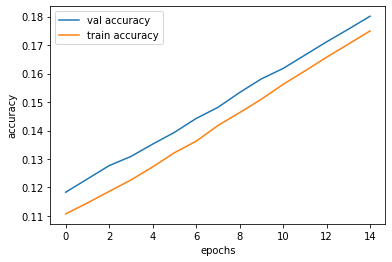

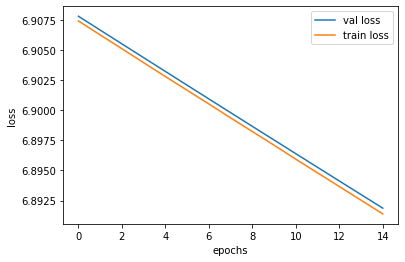

0.1801111111111111

In [22]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.3**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: 

Test Accuracy : 0.1661

Test Loss : 6.892932176589966

As we saw in the previous train, the model is improving between every epoch, but the improvement is too slow, probably because the learning rate is too low. 


#### hidden_layer_dim = 200, lr = 0.0001

Set the hidden_layer_dim to 200 and the lr to 0.0001 and train the model.

In [23]:
args['hidden_layer_dim'] = 200
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.13058823529411767, loss 6.897030549890855

Validation epoch 1: accuracy 0.13, loss 6.897295316060384
========== new best model! epoch 1, accuracy 0.13  ==========

Train epoch 2: accuracy 0.13554901960784313, loss 6.89571185205497

Validation epoch 2: accuracy 0.136, loss 6.895966688791911
========== new best model! epoch 2, accuracy 0.136  ==========

Train epoch 3: accuracy 0.1416470588235294, loss 6.8943496217914655

Validation epoch 3: accuracy 0.142, loss 6.894639756944445
========== new best model! epoch 3, accuracy 0.142  ==========

Train epoch 4: accuracy 0.1470392156862745, loss 6.893030175975725

Validation epoch 4: accuracy 0.148, loss 6.893314944373237
========== new best model! epoch 4, accuracy 0.148  ==========

Train epoch 5: accuracy 0.15205882352941177, loss 6.891689178990383

Validation epoch 5: accuracy 0.153, loss 6.8919919861687555
========== new best model! epoch 5, accuracy 0.153  ==========

Train epoch 6: accuracy 0.1586078431372549

Best val accuracy was 0.21511111111111114, at epoch 14


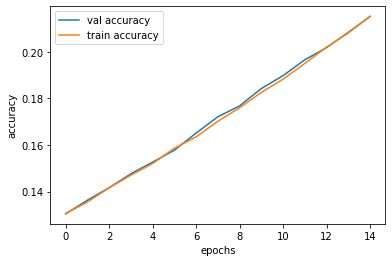

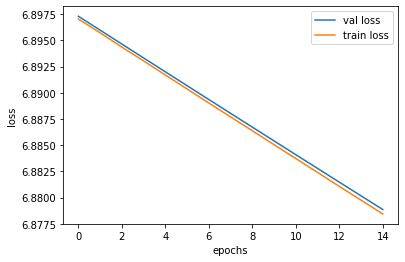

0.21511111111111114

In [25]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.4**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: 

Test Accuracy : 0.22359999999999997

Test Loss : 6.876294708251953

We can see from those graphs that train and test sets get almost the same results. That means that the model isn't learning only the test samples (overfitting), but that it exceeds to get the same accuracy for both graphs as well. 
As for the LR, its low value affects the model as we described above.

### Finetuning learning rate

#### hidden_layer_dim = 100, lr = 0.000001

Set the hidden_layer_dim to 100 and the lr to 0.000001 and train the model.

In [26]:
args['hidden_layer_dim'] = 100
args['lr']=0.000001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.10807843137254902, loss 6.907954823737051

Validation epoch 1: accuracy 0.114, loss 6.908920976850721
========== new best model! epoch 1, accuracy 0.114  ==========

Train epoch 2: accuracy 0.10868627450980392, loss 6.907939406002269

Validation epoch 2: accuracy 0.114, loss 6.908909691704644

Train epoch 3: accuracy 0.10837254901960784, loss 6.907931496115292

Validation epoch 3: accuracy 0.114, loss 6.908898406558567

Train epoch 4: accuracy 0.10809803921568627, loss 6.907909505507526

Validation epoch 4: accuracy 0.114, loss 6.908887227376302

Train epoch 5: accuracy 0.1085490196078431, loss 6.90789701424393

Validation epoch 5: accuracy 0.114, loss 6.908875624338786

Train epoch 6: accuracy 0.10801960784313726, loss 6.907897051642923

Validation epoch 6: accuracy 0.114, loss 6.908864127265082

Train epoch 7: accuracy 0.10882352941176471, loss 6.907891516591988

Validation epoch 7: accuracy 0.114, loss 6.908852842119005

Train epoch 8: accuracy 0.108784313

Best val accuracy was 0.11455555555555555, at epoch 12


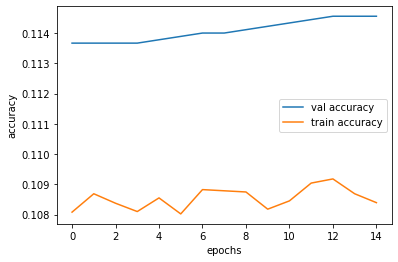

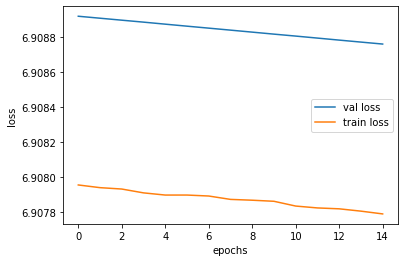

0.11455555555555555

In [27]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 3.1**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: 

Test Accuracy : 0.0982

Test Loss : 6.910411262512207

We can se that between the epochs the accuaracy and loss rate is barely change, the LR is too low.



#### hidden_layer_dim = 100, lr = 0.1

Set the hidden_layer_dim to 1 and the lr to 0.1 and train the model.

In [28]:
args['hidden_layer_dim'] = 100
args['lr']= 0.1
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.6676274509803921, loss 6.412360799078848

Validation epoch 1: accuracy 0.777, loss 5.957913398742676
========== new best model! epoch 1, accuracy 0.777  ==========

Train epoch 2: accuracy 0.8100196078431371, loss 5.698351719800164

Validation epoch 2: accuracy 0.834, loss 5.505653699239095
========== new best model! epoch 2, accuracy 0.834  ==========

Train epoch 3: accuracy 0.849921568627451, loss 5.393932660420735

Validation epoch 3: accuracy 0.861, loss 5.304966767628987
========== new best model! epoch 3, accuracy 0.861  ==========

Train epoch 4: accuracy 0.8716862745098038, loss 5.244462966918945

Validation epoch 4: accuracy 0.876, loss 5.194281260172526
========== new best model! epoch 4, accuracy 0.876  ==========

Train epoch 5: accuracy 0.8829215686274512, loss 5.155746693704643

Validation epoch 5: accuracy 0.886, loss 5.125640445285374
========== new best model! epoch 5, accuracy 0.886  ==========

Train epoch 6: accuracy 0.8905882352941176, l

Best val accuracy was 0.9143333333333332, at epoch 14


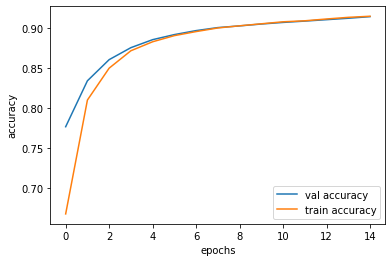

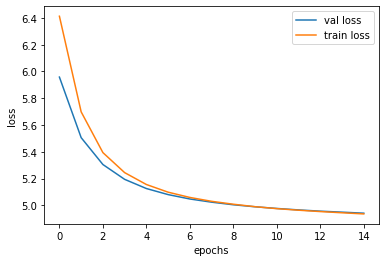

0.9143333333333332

In [29]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 3.2**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: 

Test Accuracy : 0.9206999999999999

Test Loss : 4.920141315460205

Based on the learning rate and hidden layer dimension, we can see that both the accuracy and the loss are improving significantly between epochs, for both train and validation sets.
As we said before because of the low learning rate, we didn't improve between epochs. Now we can see the effect of higher learning rate.


#### hidden_layer_dim = 100, lr = 0.001

Set the hidden_layer_dim to 100 and the lr to 0.001 and train the model.

In [30]:
args['hidden_layer_dim'] = 100
args['lr']=0.001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.13005882352941175, loss 6.902335176280901

Validation epoch 1: accuracy 0.158, loss 6.897520383199056
========== new best model! epoch 1, accuracy 0.158  ==========

Train epoch 2: accuracy 0.17664705882352946, loss 6.890936468161788

Validation epoch 2: accuracy 0.201, loss 6.886255052354601
========== new best model! epoch 2, accuracy 0.201  ==========

Train epoch 3: accuracy 0.22172549019607843, loss 6.879695350048589

Validation epoch 3: accuracy 0.241, loss 6.875132984585232
========== new best model! epoch 3, accuracy 0.241  ==========

Train epoch 4: accuracy 0.260921568627451, loss 6.868574329451019

Validation epoch 4: accuracy 0.278, loss 6.864138868119982
========== new best model! epoch 4, accuracy 0.278  ==========

Train epoch 5: accuracy 0.297078431372549, loss 6.857586346420587

Validation epoch 5: accuracy 0.31, loss 6.853257073296441
========== new best model! epoch 5, accuracy 0.31  ==========

Train epoch 6: accuracy 0.33050980392156865, 

Best val accuracy was 0.5555555555555556, at epoch 14


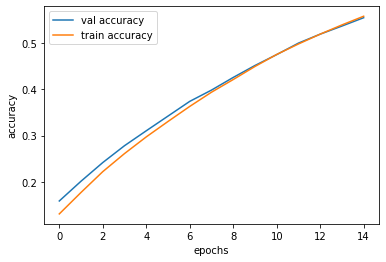

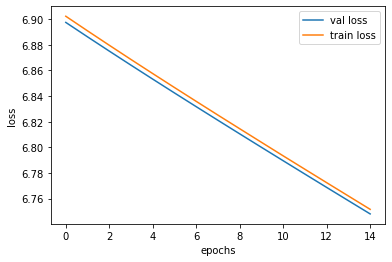

0.5555555555555556

In [31]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 3.3**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: 

Test Accuracy : 0.5748

Test Loss : 6.745584630966187

the accuracy and loss got worst from last attempt, the only thing we changed is to decrease the LR.

Again, the improvements between epochs are too slow - the LR is too small.

**QUESTION 4:** : Suggest a way to improve the results by changing the networks's architecture  

**ANSWER**:

It is possible to create more hidden layers.

The more hidden layers we add to the model, the deeper the model can learn, meaning it will learn more distinctive and unique features through each hidden layer. 




## Explainability

Here we will plot some of the network weights

(784, 100)


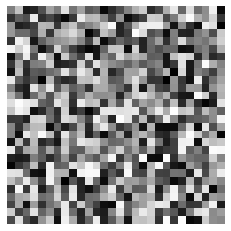

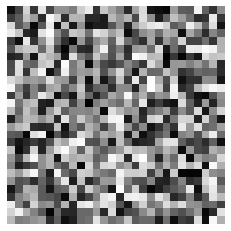

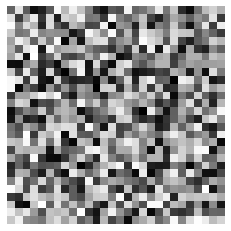

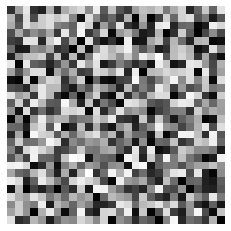

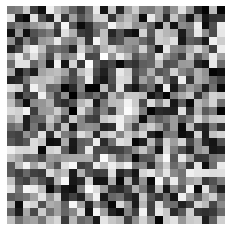

In [32]:
# Visualize some weights. features of digits should be somehow present.
def show_net_weights(net_params):
    W1 = net_params.fc1.weight.cpu().data.numpy().T
    print(W1.shape)
    for i in range(5):
        W = W1[:,i*5].reshape(28, 28)
        plt.imshow(W,cmap='gray')
        plt.axis('off')
        plt.show()

show_net_weights(best_model)


**QUESTION 5:** Where are the bright regions? why?

**ANSWER:** 

the brightest region can be found in the middle.

The reason is that the most of the features can be found in the center area of any photo of digit.